In this page we will continue from the LinearExample notebook, choosing to use the covariance summary statistics for the linear example. We will use a custom class to aim to increase customisability as well as trying to use dropout to get a distribution of outputs.

### Imports

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

print("Successfully imported all modules")

Successfully imported all modules


### All Parameters

Can change the parameters here and re-run

In [67]:
no_params = 10
epochs = 200
patience_early_stopping = 10  # Early-stopping window
neurons_per_layer = 64
dropout_prob = 0.2
always_on_dropout = True  # Keep dropout active at test time

batch_size = 256  # tf.data batch size
theta_range = (0.0, 10.0)
n_per_sample = 500  # points (x, y) per simulated data-set
noise_std = 0.5
n_examples = 20_000  # simulated data-sets to learn from

# evaluation
no_test_samples = 10_000
mc_samples = 50  # Monte-Carlo dropout passes

### plot helper function

In [68]:
def plot_loss(history: tf.keras.callbacks.History,
              title: str = "Loss curve") -> None:
    """Plot training & validation loss curves (linear + semilog-y).
    Generates two stacked panels:
       • top: linear y-axis
       • bottom: semilog-y (base-10) axis """
    epochs = range(1, len(history.history["loss"]) + 1)

    fig, (ax_lin, ax_log) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # linear plot
    ax_lin.plot(epochs, history.history["loss"], label="train")
    ax_lin.plot(epochs, history.history["val_loss"], label="val")
    ax_lin.set_ylabel("MSE")
    ax_lin.set_title(title + " (linear scale)")
    ax_lin.legend()
    ax_lin.grid(True, which="both", linestyle="--", linewidth=0.5)

    # semilog-y plot
    ax_log.semilogy(epochs, history.history["loss"], label="train")
    ax_log.semilogy(epochs, history.history["val_loss"], label="val")
    ax_log.set_xlabel("Epoch")
    ax_log.set_ylabel("MSE (log scale)")
    ax_log.set_title(title + " (semilogy)")
    ax_log.legend()
    ax_log.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


### Custom NN

As before use keras.

Define our custom Neural Network, can add or remove layers accordingly

In [69]:
class NN(Model):
    """Two-layer MLP with optional always-on dropout."""

    def __init__(self,
                 no_params: int,
                 neurons: int,
                 dropout_prob: float = 0.0,
                 always_on_dropout: bool = False):
        super(NN, self).__init__(name='NN')  # inherits the parent class and names it (for debugging)

        self.neurons = neurons
        self.no_params = no_params  # number of parameters we output
        self.always_on_dropout = always_on_dropout  # if true then we leave on for test passes

        # Define our layers
        self.l1 = Dense(neurons, activation='relu', name='l1')
        self.do1 = Dropout(rate=dropout_prob, name='do1')  # dropout layer 1
        self.l2 = Dense(neurons, activation='relu', name='l2')
        self.do2 = Dropout(rate=dropout_prob, name='do2')  # dropout layer 2
        self.out = Dense(no_params, activation="linear", name="out")  # Applies linear activation

    def call(self,
             inputs: tf.Tensor,
             training: bool = False) -> tf.Tensor:
        """Forward pass with dropout flag logic."""
        dropout_flag = training or self.always_on_dropout

        # Apply our custom layers
        x = self.l1(inputs)
        x = self.do1(x, training=dropout_flag)
        x = self.l2(x)
        x = self.do2(x, training=dropout_flag)
        x = self.out(x)
        return x  # output size = no_params


### Dataset generation

We make a similar function to before with only the one covariance option.

The scaling helps significantly to get good convergence

In [70]:
def simulate_batch(no_params: int,
                   batch_size: int,
                   theta_range: tuple,
                   n_per_sample: int,
                   noise_std: float):
    """Simulate one batch of (summary, θ, 1) pairs."""
    # Generate our theta, and random points which will be used to form the output variable
    theta = tf.random.uniform([batch_size, no_params, 1], *theta_range)  # (B, D, 1)
    X = tf.random.uniform([batch_size, n_per_sample, no_params])  # (B, n, D)

    # Generate noise and then create output variable
    noise = noise_std * tf.random.normal([batch_size, n_per_sample, 1])  # (B, n, 1)
    y = tf.matmul(X, theta) + noise  # (B, n, 1)

    mean_x = tf.reduce_mean(X, axis=1)  # (B, D)
    mean_y = tf.reduce_mean(y, axis=1)  # (B, 1)

    # Center both x and y around their mean
    xc = X - tf.expand_dims(mean_x, 1)
    yc = y - tf.expand_dims(mean_y, 1)

    # Create the covariance matrix for the data, then the covariance between x and y
    cov_x = tf.matmul(xc, xc, transpose_a=True) / n_per_sample  # (B, D, D)
    cov_xy = tf.matmul(xc, yc, transpose_a=True) / n_per_sample  # (B, D, 1)

    summary = tf.concat([
        mean_x,
        mean_y,
        tf.reshape(cov_x, [-1, no_params * no_params]),
        tf.reshape(cov_xy, [-1, no_params]),
    ], axis=-1)  # (B, D² + 2D + 1)

    return summary, theta


def make_dataset_multi_dim(n_examples: int,
                           no_params: int,
                           batch_size: int) -> tf.data.Dataset:
    """Create a tf.data pipeline emitting un-batched (summary, θ) pairs."""
    steps = n_examples // batch_size
    ds = tf.data.Dataset.range(steps).map(
        lambda _: simulate_batch(no_params,
                                 batch_size,
                                 theta_range,
                                 n_per_sample,
                                 noise_std),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()
    return ds.prefetch(tf.data.AUTOTUNE)


In [71]:
train_ds = make_dataset_multi_dim(
    n_examples=int(n_examples * 0.9),
    no_params=no_params,
    batch_size=batch_size
)
val_ds = make_dataset_multi_dim(
    n_examples=int(n_examples * 0.1),
    no_params=no_params,
    batch_size=batch_size
)

Now initialise the model defining the optimiser too

In [72]:
input_size = no_params ** 2 + 2 * no_params + 1

myNN = NN(neurons=neurons_per_layer,
          no_params=no_params,
          dropout_prob=dropout_prob,
          always_on_dropout=always_on_dropout)
myNN.compile(loss='mse', optimizer="adam")

Fit the model

Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.7439 - val_loss: 9.3166
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2624 - val_loss: 8.5828
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4812 - val_loss: 8.2021
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0394 - val_loss: 7.7113
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6391 - val_loss: 7.2371
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1391 - val_loss: 6.7902
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6952 - val_loss: 6.2929
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1347 - val_loss: 5.7452
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6215 - val_loss: 5.1369
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9982 - val_loss: 4.5888
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4409 - val_loss: 4.0279
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ l1 (Dense)                      │ (None, 64)             │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do1 (Dropout)                   │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Dense)                      │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do2 (Dropout)                   │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,856 (147.88 KB)

 Trainable params: 12,618 (49.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,238 (98.59 KB)

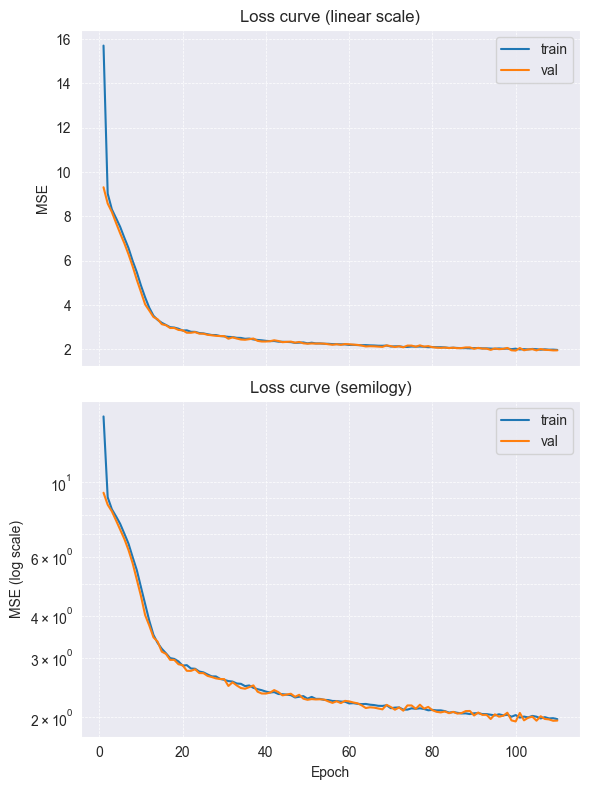

In [73]:
history = myNN.fit(
    train_ds.batch(batch_size),
    validation_data=val_ds.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
myNN.summary()
plot_loss(history)

### Results

Now we look to see how it performs on the data, as mentioned we keep dropout on during testing and will take a point estimate

In [74]:
def average_relative_error(model: tf.keras.Model,
                           batchsize: int,
                           no_tests: int,
                           mc_samples: int,
                           n_per_sample: int,
                           noise_std: float,
                           theta_range: tuple) -> float:
    """Estimate mean relative error with Monte-Carlo dropout."""
    # Simulate a fresh batch
    summaries, theta_true = simulate_batch(
        no_params,
        batch_size=no_tests,
        theta_range=theta_range,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
    )  # shapes: (N, ·) and (N, D, 1)
    theta_true_np = np.squeeze(theta_true.numpy(), axis=-1)  # (N, D)

    # Monte-Carlo dropout passes
    preds = [
        model.predict(summaries, batch_size=batchsize, verbose=0)
        for _ in range(mc_samples)
    ]
    theta_pred_mean = np.mean(np.stack(preds, axis=0), axis=0)  # (N, D)

    # compute the relative error
    eps = 1e-8
    diff = theta_pred_mean - theta_true_np  # (N, D)
    numer = np.linalg.norm(diff, axis=1)  # ‖θ̂ – θ‖₂
    denom = np.linalg.norm(theta_true_np, axis=1) + eps
    return (numer / denom).mean()


In [76]:
avg_re = average_relative_error(
    model=myNN,
    batchsize=batch_size,
    no_tests=no_test_samples,
    mc_samples=mc_samples,
    n_per_sample=n_per_sample,
    noise_std=noise_std,
    theta_range=theta_range
)
print(f"Average relative error (MC-{mc_samples}): {avg_re:.4f}")

Average relative error (MC-50): 0.1390
